# **The Battle of Neighborhoods** Week1

Author: Chary Mariñas   
Date: August 2020

### **Business case**

*Due to the current situation with the coronavirus, the data has radically changed so the statistics could not be representative right now.*  
&nbsp;                                               
According to the tourism page of the Community of Madrid, the city of Madrid registered in 2019 the arrival of 10.4 million visitors (+ 2.1% vs 2018), of which 55% were international and 45 % national. 22.6 million overnight stays were generated (+ 5.7% vs 2018). The main source markets for international tourism were the United States, Italy, France, the United Kingdom and Germany, and those that grew the most were the United States, China, Italy, Brazil and Mexico. A total expenditure of 10,451 million (+ 12.6% vs 2018) and an average daily expenditure of 270 euros (+ 11% vs 2018) was reached in the Community of Madrid.( [+info](https://www.madrid-destino.com/turismo/estadisticas#:~:text=La%20ciudad%20de%20Madrid%20registr%C3%B3,%2C7%25%20vs%202018).)

A tourist who comes to visit Madrid may have a great dilemma with where to stay, so we will analyze the best places based on the offer and services in the Centro district.

### **Data**

Dataset sources for this project will be: 

1.Madrid apartment listing from the Inside Airbnb site - [+info](http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-07-17/data/listings.csv.gz)
&nbsp; 

2.Madrid Neighborhoods Tabulation Areas from Inside Airbnb site - [+info](http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-07-17/visualisations/neighbourhoods.geojson)
&nbsp; 

3.Foursquare API to extract data about venues - food places, museums, galleries, shopping centers, sightseeing attractions, concert halls and so on


In [7]:
import pandas as pd
import locale
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import json
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans
import matplotlib.path as mpltPath

locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',None)

In [9]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-3.0           |   py36h45558ae_0         640 KB  conda-forge
    folium-0.5.0               |             py

In [8]:
import folium
from folium import plugins

### READING MADRID APARTMENT LISTING:

In [9]:
apartment_url = 'http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-07-17/data/listings.csv.gz'

df_apar= pd.read_csv(apartment_url, low_memory=False)
df_apar.shape

(21255, 106)

In [10]:
df_apar.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

In [11]:
df_apar.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6369,https://www.airbnb.com/rooms/6369,20200717213202,2020-07-18,"Rooftop terrace room , ensuite bathroom","Excellent connection with the AIRPORT and EXHIBITION GROUNDS IFEMA Lively neighboorhood with shops, bars, restaurants and supermarkets.","BETTER THAN A HOTEL.Upscale neighboorhood (Metro Colombia direct to airport,super convenient entrance right next to the building ). Lots of shops. 20min by public transport to downtown (direct bus or subway). The non smoking room ,(16sqm/ 180sqfeet) with double bed , has lots of privacy with its own ENSUITE BATHROOM-inside the room- and a door with direct access to the huge sunny and full of plants terraCEe(620 sq feet / 60 sqm)). The room has as well AIR CON / HEATING and WIFI INTERNET. Guests have full acces to the rest of the flat, including kitchen with all appliances (coffe machine, microwave, water boiler, dishwasher : no need to clean dishes!, etc... The apartment is situated in a pleasant neighborhood. Contact , please, if you need more information about the apartment, amenities or the situation where it is in Madrid , i will be happy to reply your questions. Thank you and","Excellent connection with the AIRPORT and EXHIBITION GROUNDS IFEMA Lively neighboorhood with shops, bars, restaurants and supermarkets. BETTER THAN A HOTEL.Upscale neighboorhood (Metro Colombia direct to airport,super convenient entrance right next to the building ). Lots of shops. 20min by public transport to downtown (direct bus or subway). The non smoking room ,(16sqm/ 180sqfeet) with double bed , has lots of privacy with its own ENSUITE BATHROOM-inside the room- and a door with direct access to the huge sunny and full of plants terraCEe(620 sq feet / 60 sqm)). The room has as well AIR CON / HEATING and WIFI INTERNET. Guests have full acces to the rest of the flat, including kitchen with all appliances (coffe machine, microwave, water boiler, dishwasher : no need to clean dishes!, etc... The apartment is situated in a pleasant neighborhood. Contact , please, if you need more information about the apartment, amenities or the situation where it is in Madrid , i will be happy to repl",none,Nice and definitely non touristic neighborhood with plenty of shops and restaurants. A market is across the Street

For cleaning data we will use following filters:
&nbsp;

- District = 'Centro';
- Availability >= 100 days/year; 
- Number of reviews >= 10; 
- Last Scraped/Reviewed later than 2020-04-01;
- Minimum nights >= 1;
- Excluded Hostels and Camper/RV;
- Excluded Shared rooms.

In [12]:
df_airbnb = df_apar[(df_apar.neighbourhood_group_cleansed == 'Centro')
               & (df_apar.number_of_reviews >= 10) 
               & (df_apar.availability_365 >= 100)
               & (df_apar.city=='Madrid') 
               & (df_apar.state =='Comunidad de Madrid' )
               & (df_apar.last_scraped > '2020-04-01')
               & (df_apar.last_review > '2020-04-01')
               & (~df_apar.room_type.isin(['Shared room']))
               & (~df_apar.property_type.isin(['Camper/RV', 'Hostel']))
               & (df_apar.minimum_nights < 3 )
              ].copy()
df_airbnb.shape

(396, 106)

In [13]:
df_airbnb.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
94,289555,https://www.airbnb.com/rooms/289555,20200717213202,2020-07-18,Casa Museo del Prado-Private room.,"Perfect apartment in this 19 th. century building between Prado Museum, Puerta del Sol and Plaza Cibeles. Just 5 or 10 min. walking to the Royal Palace, Plaza Mayor, Monasterio de las Descalzas reales, Salamanca neigbourhood, Botin Rest. Retiro park","This is 19 th century building and the floor is original from those days Spacious and very light full house. 4 balconies to the street and 20 windows view to two court yards. Very quite and spacious house. Next to Prado Museum and Thyssen Museum. Just 5 min from Atocha train station and Puerta del Sol, La Latina, Cibeles Fountain, Retiro Park, Royal Palace, Opera House,Convento de las Descalzas Reales, Almudena Cathedral, Hotel Ritz, etc. This will be you perfect Casa de Madrid in your Spain´s visit. I´ve got one or two rooms with balconies for traveller. Living-room and kitchen. Second floor opposite to the spanish Parliament. This area next to night life with many restaurants and bars. Three Metro stations close to our house. Stop buses and train station in this area. 15 min. walking to Salamanca neighbourhood. This is the principal shopping area in Madrid. Austria neighborhood is just 10 min walking distance where you can find The Royal Palace, Plaza Mayor and Opera house.","Perfect apartment in this 19 th. century building between Prado Museum, Puerta del Sol and Plaza Cibeles. Just 5 or 10 min. walking to the Royal Palace, Plaza Mayor, Monasterio de las Descalzas reales, Salamanca neigbourhood, Botin Rest. Retiro park This is 19 th century building and the floor is original from those days Spacious and very light full house. 4 balconies to the street and 20 windows view to two court yards. Very quite and spacious house. Next to Prado Museum and Thyssen Museum. Just 5 min from Atocha train station and Puerta del Sol, La Latina, Cibeles Fountain, Retiro Park, Royal Palace, Opera House,Convento de las Descalzas Reales, Almudena Cathedral, Hotel Ritz, etc. This will be you perfect Casa de Madrid in your Spain´s visit. I´ve got one or two rooms with balconies for traveller. Living-room and kitchen. Second floor opposite to the spanish Parliament. This area next to night 

##### Let's clean up some data: from 106 columns to 24

In [14]:
# Select subset of original columns
# Cleaning the data
# Convert Price strings into Float
# Change some Strings Columns into Numeric
df = df_airbnb[['id',  'name', 'last_review', 'listing_url', 'picture_url', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'review_scores_rating',             
             'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
              'square_feet', 'price', 'security_deposit', 'cleaning_fee',
             'minimum_nights', 'number_of_reviews_ltm', 'reviews_per_month',
             'number_of_reviews', 'availability_365']].copy()
df['price'].fillna('$0', inplace=True)
df['security_deposit'].fillna('$0', inplace=True)
df['cleaning_fee'].fillna('$0', inplace=True)
df.fillna('0', inplace=True)
df= df.astype({'bathrooms':'int','bedrooms':'int', 'square_feet':'int'})
df['price'] = df['price'].apply(lambda x: locale.atof(x.strip("$")))
df['security_deposit'] = df['security_deposit'].apply(lambda x: locale.atof(x.strip("$")))
df['cleaning_fee'] = df['cleaning_fee'].apply(lambda x: locale.atof(x.strip("$")))
df.shape

(396, 24)

In [15]:
df.head(1)

,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,square_feet,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365
94,289555,Casa Museo del Prado-Private room.,2020-05-05,https://www.airbnb.com/rooms/289555,https://a0.muscache.com/im/pictures/da28a49d-5abd-472b-9519-ac2dbfd41d9e.jpg?aki_policy=large,Centro,Cortes,90.0,40.4176,-3.69808,Apartment,Private room,4,1,1,0,28.0,0.0,68.0,1,7,2.06,172,342


### Reading Madrid District Data

In [16]:
district_url = 'http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-07-17/visualisations/neighbourhoods.csv'
    
df_mad= pd.read_csv(district_url)
df_mad.shape

(128, 2)

In [17]:
df_mad.head(1)

,neighbourhood_group,neighbourhood
0,Arganzuela,Acacias


In [18]:
!wget -q -O 'Madrid Districts.geojson' http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-07-17/visualisations/neighbourhoods.geojson 'Madrid Districts.geojson'
print('Data downloaded!')
mad_data_filename = 'Madrid Districts.geojson'

Data downloaded!


In [19]:
with open(mad_data_filename) as json_data:
    mad_data = json.load(json_data)

In [98]:
#mad_data

In [20]:
# Create Madrid Area Tabulation Data Polygons
neighborhoods_polygons = {}
for neighborhood in mad_data['features']:
    name = neighborhood['properties']['neighbourhood_group']
    neighborhoods_polygons[name] = neighborhood['geometry']

In [21]:
def define_tab_area(latitude, longitude):
    point = [[longitude,latitude]]
    for k,v in neighborhoods_polygons.items():                
        polygon_shapes = v['coordinates']      
        if len(polygon_shapes) == 1:
            path = mpltPath.Path(polygon_shapes[0][0])
            if path.contains_points(point):
                return k
        else:
            for p in polygon_shapes:
                path = mpltPath.Path(p[0])
                if path.contains_points(point):
                    return k        
    return 'Not defined'

In [22]:
define_tab_area(40.420, -3.7047)

'Centro'

In [23]:
for i in range(len(mad_data['features']) -1, -1, -1):
     if mad_data['features'][i]["properties"]["neighbourhood_group"] != 'Centro':
         del mad_data['features'][i]      


In [25]:
pip install geocoder

     |████████████████████████████████| 102kB 5.2MB/s ta 0:00:011
     |████████████████████████████████| 829kB 773kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [26]:
import geocoder

In [27]:
pip install geopy

     |████████████████████████████████| 112kB 18.6MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [28]:
from  geopy.geocoders import Nominatim
import time
neighborhoods_data = mad_data['features']
data = []
geolocator = Nominatim(user_agent="chary")
for n in neighborhoods_data:
    city_split =n['properties']['neighbourhood'].split('-')[0]
    city =n['properties']['neighbourhood']
    print(city_split)
    loc = geolocator.geocode(city_split + ", Madrid")    
    print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)
    data.append([city,loc.latitude,loc.longitude])  
    time.sleep(1)



Palacio
latitude is :- 40.41512925 
longtitude is:- -3.7156179983990922
Embajadores
latitude is :- 40.409680550000004 
longtitude is:- -3.701644426413222
Cortes
latitude is :- 40.4147791 
longtitude is:- -3.6975842
Justicia
latitude is :- 40.42395689999999 
longtitude is:- -3.6957473208550464
Universidad
latitude is :- 40.4254085 
longtitude is:- -3.7059885
Sol
latitude is :- 40.4178272 
longtitude is:- -3.702222089915074


In [29]:
neighborhoods_geo = pd.DataFrame(data, columns = ['Neighborhood', 'Latitude', 'Longitude'])
neighborhoods_geo

,Neighborhood,Latitude,Longitude
0,Palacio,40.415129,-3.715618
1,Embajadores,40.409681,-3.701644
2,Cortes,40.414779,-3.697584
3,Justicia,40.423957,-3.695747
4,Universidad,40.425409,-3.705989
5,Sol,40.417827,-3.702222


### For the analysis, it is interesting that we calculate the price per person for the Airbnb places and the final one, adding the cleaning fee

In [30]:
df['price_per_person'] =  (df['price'] + df['cleaning_fee'])/df['accommodates']
df['full_price'] = df['price'] + df['cleaning_fee']

#### Let's find the outliers by neighbourhood in the Centro district

Text(0.5, 0.98, '')

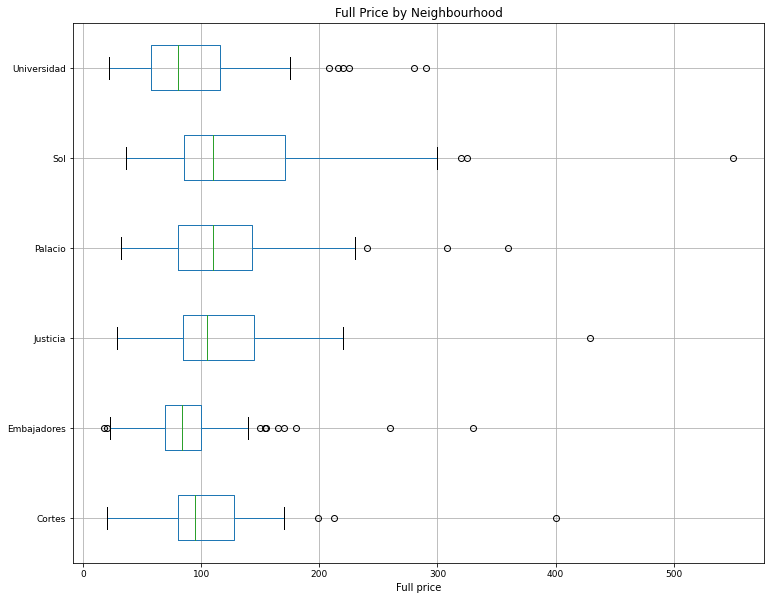

In [31]:
bp = df[['neighbourhood_cleansed','full_price']].boxplot(column='full_price', by='neighbourhood_cleansed',vert=False, fontsize=9, figsize=(12,10) )
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

#### Best way to proceed is to delete the outliers

In [32]:
Q1 = df['full_price'].quantile(0.25)
Q3 = df['full_price'].quantile(0.75)
IQR = Q3 - Q1

filter = (df['full_price'] >= Q1 - 1.5 * IQR) & (df['full_price'] <= Q3 + 1.5 *IQR)
df_airnb_norm = df.loc[filter]  
df_airnb_norm.shape

(370, 26)

Text(0.5, 0.98, '')

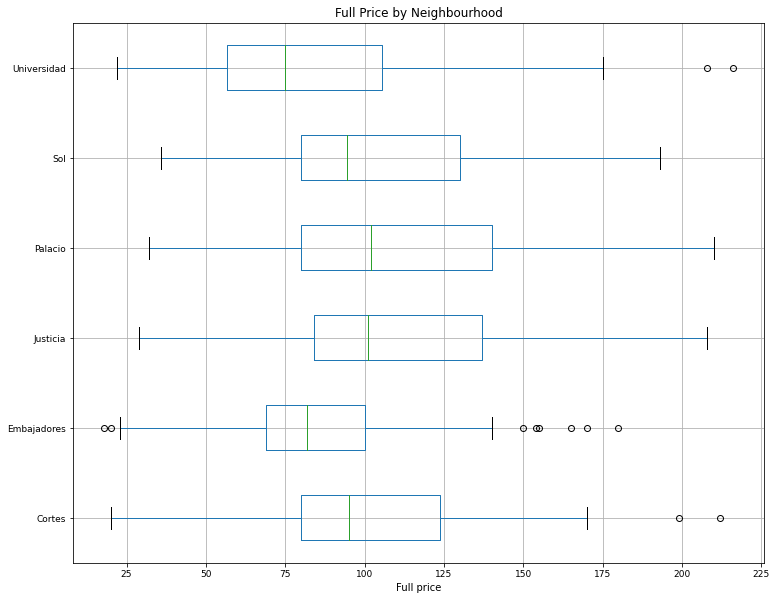

In [33]:
bp = df_airnb_norm[['neighbourhood_cleansed','full_price']].boxplot(column='full_price', by='neighbourhood_cleansed',vert=False, fontsize=9, figsize=(12,10))
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

### Let's aggregate all the data together

In [34]:
neighbourhood_price_merged = df_airnb_norm.copy()
neighbourhood_price_merged = neighbourhood_price_merged.groupby("neighbourhood_cleansed", as_index=False).agg({'price_per_person':'mean', 'accommodates':'count'})
neighbourhood_price_merged.columns=['neighbourhood_cleansed', 'mean_price_per_person', 'accommodates']

In [35]:
neighbourhood_price_merged[['neighbourhood_cleansed', 'mean_price_per_person', 'accommodates']].sort_values('mean_price_per_person')

,neighbourhood_cleansed,mean_price_per_person,accommodates
0,Cortes,25.212212,62
5,Universidad,26.012543,56
4,Sol,27.275000,54
1,Embajadores,27.424786,100
3,Palacio,27.472275,53
2,Justicia,32.534444,45


### Let's add Madrid Areas Centroid latitude/longitude to our neighbourhood statistic data frame to display them on the map

In [36]:
neighbourhood_price_geo = neighbourhood_price_merged.copy()
neighbourhood_price_geo = neighbourhood_price_geo.merge(neighborhoods_geo[['Latitude', 'Longitude','Neighborhood']], how = 'left', left_on = 'neighbourhood_cleansed', right_on = 'Neighborhood').drop(columns= ['Neighborhood'])

In [37]:
neighbourhood_price_geo[['neighbourhood_cleansed', 'mean_price_per_person', 'accommodates', 'Latitude','Longitude']].sort_values('mean_price_per_person')

,neighbourhood_cleansed,mean_price_per_person,accommodates,Latitude,Longitude
0,Cortes,25.212212,62,40.414779,-3.697584
5,Universidad,26.012543,56,40.425409,-3.705989
4,Sol,27.275000,54,40.417827,-3.702222
1,Embajadores,27.424786,100,40.409681,-3.701644
3,Palacio,27.472275,53,40.415129,-3.715618
2,Justicia,32.534444,45,40.423957,-3.695747


In [38]:
neighbourhood_price_geo = neighbourhood_price_geo[['neighbourhood_cleansed', 'mean_price_per_person', 'accommodates', 'Latitude','Longitude']].sort_values('mean_price_per_person')

#### Data sorted by mean price per person

In [39]:
neighbourhood_price_geo.reset_index(inplace=True)

In [40]:
neighbourhood_price_geo

,index,neighbourhood_cleansed,mean_price_per_person,accommodates,Latitude,Longitude
0,0,Cortes,25.212212,62,40.414779,-3.697584
1,5,Universidad,26.012543,56,40.425409,-3.705989
2,4,Sol,27.275000,54,40.417827,-3.702222
3,1,Embajadores,27.424786,100,40.409681,-3.701644
4,3,Palacio,27.472275,53,40.415129,-3.715618
5,2,Justicia,32.534444,45,40.423957,-3.695747


## Foursquare API Neighborhoods Analysis

In [41]:
limit=100
df_airbnb_top = df_airnb_norm.sort_values(by=['review_scores_rating','full_price','price_per_person'], ascending=[False, True, True])[['name','neighbourhood_cleansed','latitude', 'longitude' ,'review_scores_rating',  'property_type', 'room_type', 'accommodates', 'full_price', 'price_per_person', 'listing_url','picture_url','bathrooms', 'bedrooms','square_feet']].head(limit)


In [42]:
df_airbnb_top.head(5)

,name,neighbourhood_cleansed,latitude,longitude,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,listing_url,picture_url,bathrooms,bedrooms,square_feet
17101,Madrid Centro - Latina Plaza Mayor Apartamento,Embajadores,40.40929,-3.70979,100.0,Apartment,Entire home/apt,4,80.0,20.000000,https://www.airbnb.com/rooms/39858092,https://a0.muscache.com/im/pictures/335b89df-25b1-4021-b23d-31958136d4d1.jpg?aki_policy=large,1,2,0
18098,APARTMENT IN MADRID'S TRENDY HEART,Justicia,40.42361,-3.69921,100.0,Apartment,Entire home/apt,5,109.0,21.800000,https://www.airbnb.com/rooms/41022326,https://a0.muscache.com/im/pictures/68af19a9-ff3d-43f2-856c-0a02f025723e.jpg?aki_policy=large,1,1,0
18417,Apartamento VIP Madrid Centro III,Embajadores,40.40766,-3.70161,100.0,Apartment,Entire home/apt,6,115.0,19.166667,https://www.airbnb.com/rooms/41424380,https://a0.muscache.com/im/pictures/9eed8827-dd52-4421-ac6e-279403f1f685.jpg?aki_policy=large,1,2,0
7536,Diseño vanguardista con espectaculares vistas a la Plaza de Santa Ana,Cortes,40.41495,-3.70061,100.0,Apartment,Entire home/apt,3,120.0,40.000000,https://www.airbnb.com/rooms/21907666,"https://a0.muscache.com/4ea/air/v2//pictures/96d0b439-937e-434f-9e51-c893be86d2f3.jpg?t=r:w1200-h720-sfit,e:fjpg-c85",1,1,0
19124,Cozy APARTAMENT close to Plaza Callao,Sol,40.41987,-3.70763,100.0,Apartment,Entire home/apt,4,139.0,34.750000,https://www.airbnb.com/rooms/42224131,https://a0.muscache.com/im/pictures/3300f815-535f-4bc9-ad57-548251536983.jpg?aki_policy=large,1,0,0


In [43]:
CLIENT_ID = 'D4SLOGGRKBFHIYUS13WA3STOQY1XVTJFN2AI4HTBDOHXVCRP' # your Foursquare ID
CLIENT_SECRET = 'KCGE0E0ZIACJCQYOJOX212MH0KF41ZUHRI244VCWHZK0ZLXI' # your Foursquare Secret
VERSION = '20200815' # Foursquare API version
LIMIT = 50
RADIUS = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D4SLOGGRKBFHIYUS13WA3STOQY1XVTJFN2AI4HTBDOHXVCRP
CLIENT_SECRET:KCGE0E0ZIACJCQYOJOX212MH0KF41ZUHRI244VCWHZK0ZLXI


In [44]:
def getAccomodatesNearbyVenues(names, latitudes, longitudes, radius, limit):
    venues_list=[]
    nearby_venues = pd.DataFrame()
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        try:
            response = requests.get(url)
            if response.status_code == 200: 
                results = response.json()["response"]['groups'][0]['items']
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])

                nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
                nearby_venues.columns = ['name', 
                                         'latitude', 
                                         'longitude', 
                                         'Venue', 
                                         'Venue Latitude', 
                                         'Venue Longitude', 
                                         'Venue Category']
            else:
                print ("Exception during call URL={} , Code={}, Text={}".format(url, response.status_code, response.text))
        except Exception as e:
            print ("Exception: {}".format(e))
            raise e
    
    return(nearby_venues)

In [45]:
df_airbnb_top_venues = getAccomodatesNearbyVenues(names=df_airbnb_top['name'],
                                   latitudes=df_airbnb_top['latitude'],
                                   longitudes=df_airbnb_top['longitude'],
                                   radius = RADIUS,
                                   limit = LIMIT
                                  )

Madrid Centro - Latina Plaza Mayor Apartamento
APARTMENT IN MADRID'S TRENDY HEART
Apartamento VIP Madrid Centro III
Diseño vanguardista con espectaculares vistas a la Plaza de Santa Ana
Cozy APARTAMENT close to Plaza Callao
Apartamento Loving Madrid Gran Vía. Muy céntrico!
Diseño y confort en la Plaza de las Flores
Center Malasaña
vacaciones para 2 "Lavapies"
Cosy Room in Chueca
LOVELY  IMMACULATE  2 BR FLAT IN OLD MADRID
Los tejados de Aratz
MODERN HOME WAITING 4U TO FALL IN LOVE WITH MADRID
**Center Luxurious Apartment. Museum Mile Wifi,A/C
AMAZING PENTHOUSE. ROYAL PALACE
M8 SOL a estrenar en Puerta del Sol.
Luxury PZA MAYOR/La Latina 2BD* 2BATH*, 6p max
Luxury duplex 10 min from Gran Via!Ask 4 Parking!!
Sophisticated & refurbished-1BD 1BTH-Colon-Centre
SANTA ANA 4 Bdr, 3 bath,
NEW! ELEGANCE PLAZA MAYOR DELUXE
New! Center Atocha-Huertas -Puerta del Sol 1
Comfortable room in Madrid downtown
Natural B
FREE WIFI VINTAGE 2 APARTMENT. CENTER MADRID.
Attic bedroom with character at Sol
Pen

In [46]:
df_airbnb_top_venues.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,La Tienda de la Cerveza,40.410546,-3.708128,Food & Drink Shop
1,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Ruda Café,40.410486,-3.708000,Coffee Shop
2,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Pajaritos Mojados,40.410524,-3.710317,Bar
3,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Almacén de Vinos - Casa Gerardo,40.409294,-3.711881,Bar
4,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,MartinaCocina,40.410001,-3.707294,Café


In [47]:
df_airbnb_top_venues.shape

(5000, 7)

### Let's define our custom Top Level categories for Venues

In [48]:
fine_art_cat = ['Art','Arts','Museum', 'Library','Exhibit','Gallery']
eat_place_cat = ['Restaurant','Steakhouse']
shopping_cat = ['Shopping Mall','Market','Boutique']
outdoor_cat = ['Sculpture Garden','Outdoor Sculpture','Monument / Landmark',
               'Memorial Site','Lighthouse','Historic Site','Fountain','Event Space','Bridge',
               'Waterfront','Church','Building','Garden','Historic Site','Lake','Park',
               'Rest Area','River','Synagogue','Field']
entertainment_cat = ['Nightclub','Club', 'Stadium', 'Pub','Theater','Opera', 'Concert']

#Join all categories' values in one
tourists_categories = fine_art_cat + eat_place_cat + shopping_cat + outdoor_cat +entertainment_cat

In [49]:
def check(category):
    if any(word in category for word in tourists_categories):
        return True
    return False

In [50]:
def change_categoty(name):
    if any(word in name for word in entertainment_cat):
        return 'Entertainment'
    if any(word in name for word in fine_art_cat):
        return 'Fine Art'
    if any(word in name for word in eat_place_cat):
        return 'Food Place'
    if any(word in name for word in shopping_cat):        
        return 'Shopping'
    if any(word in name for word in outdoor_cat):            
        return 'Sightseeing'
    if any(word in name for word in tansportation_cat):            
        return 'Transportation'

In [51]:
# Define Top Venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)      
    return row_categories_sorted.index.values[0:num_top_venues] 

def return_most_common_venues_stats(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).astype(float)      
    return row_categories_sorted.values[0:num_top_venues]

In [54]:
df_airbnb_top_venues_f = df_airbnb_top_venues[df_airbnb_top_venues['Venue Category'].apply(lambda x: check(x))].copy()
df_airbnb_top_venues_f.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Toga,40.411118,-3.706673,Spanish Restaurant
6,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,El Capricho Extremeño,40.407090,-3.708261,Tapas Restaurant
8,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Casa Dani,40.409235,-3.711055,Tapas Restaurant
13,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Casa Lucio,40.412073,-3.709701,Spanish Restaurant
14,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Puerta de Toledo,40.406720,-3.711625,Monument / Landmark


In [55]:
df_airbnb_top_venues_f.rename(columns = {'Venue Category':'Venue Type'}, inplace = True)

In [56]:
df_airbnb_top_venues_f['Venue Category'] = df_airbnb_top_venues_f['Venue Type'].apply(lambda x: change_categoty(x))
df_airbnb_top_venues_f.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Type,Venue Category
5,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Toga,40.411118,-3.706673,Spanish Restaurant,Food Place
6,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,El Capricho Extremeño,40.407090,-3.708261,Tapas Restaurant,Food Place
8,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Casa Dani,40.409235,-3.711055,Tapas Restaurant,Food Place
13,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Casa Lucio,40.412073,-3.709701,Spanish Restaurant,Food Place
14,Madrid Centro - Latina Plaza Mayor Apartamento,40.40929,-3.70979,Puerta de Toledo,40.406720,-3.711625,Monument / Landmark,Sightseeing


In [61]:
#Calculate Top3 Venues for each place
airbnb_onehot = pd.get_dummies(df_airbnb_top_venues_f[['Venue Category']], prefix="", prefix_sep="")

# add name column back to dataframe
airbnb_onehot['name'] = df_airbnb_top_venues_f['name'] 

# move name column to the first column
fixed_columns = [airbnb_onehot.columns[-1]] + list(airbnb_onehot.columns[:-1])
airbnb_onehot = airnb_onehot[fixed_columns]
airbnb_grouped = (np.round(airbnb_onehot.groupby('name').mean(),2)).reset_index()
airbnb_grouped.head()

,name,Entertainment,Fine Art,Food Place,Shopping,Sightseeing
0,"****Studio Centre-Live-In Atocha-WiFi,A/C ****",0.15,0.22,0.48,0.04,0.11
1,"***Loft Centre- Reina Sofia-Atocha-WiFi, A/C***",0.15,0.22,0.48,0.04,0.11
2,"***Loft Centre-Museum Mile, WiFi, A/C***",0.14,0.21,0.43,0.04,0.18
3,"***Studio Centre-Live-In Atocha-WiFi,A/C ***",0.17,0.21,0.54,0.04,0.04
4,"**Center Luxurious Apartment. Museum Mile Wifi,A/C",0.11,0.22,0.48,0.04,0.15


In [66]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Share'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Share'.format(ind+1))        
        

# create a new dataframe
airbnb_venues_sorted = pd.DataFrame(columns=columns)
airbnb_venues_sorted['name'] = airbnb_grouped['name']

for ind in np.arange(airbnb_grouped.shape[0]):
    strings_stats = np.around(return_most_common_venues_stats(airbnb_grouped.iloc[ind, :], num_top_venues),2) 
    strings_category = return_most_common_venues(airbnb_grouped.iloc[ind, :], num_top_venues)
    airbnb_venues_sorted.iloc[ind, 1:] = np.concatenate([strings_category,strings_stats ])

airbnb_venues_sorted.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,"****Studio Centre-Live-In Atocha-WiFi,A/C ****",Food Place,Fine Art,Entertainment,0.48,0.22,0.15
1,"***Loft Centre- Reina Sofia-Atocha-WiFi, A/C***",Food Place,Fine Art,Entertainment,0.48,0.22,0.15
2,"***Loft Centre-Museum Mile, WiFi, A/C***",Food Place,Fine Art,Sightseeing,0.43,0.21,0.18
3,"***Studio Centre-Live-In Atocha-WiFi,A/C ***",Food Place,Fine Art,Entertainment,0.54,0.21,0.17
4,"**Center Luxurious Apartment. Museum Mile Wifi,A/C",Food Place,Fine Art,Sightseeing,0.48,0.22,0.15


### Let's run k-means to cluster the neighborhood into 3 clusters.

In [62]:
# set number of clusters
kclusters = 3

airbnb_grouped_clustering = airbnb_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(airbnb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 0], dtype=int32)

In [67]:
airbnb_venues_clustered = airbnb_venues_sorted.copy()
airbnb_venues_clustered.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,"****Studio Centre-Live-In Atocha-WiFi,A/C ****",Food Place,Fine Art,Entertainment,0.48,0.22,0.15
1,"***Loft Centre- Reina Sofia-Atocha-WiFi, A/C***",Food Place,Fine Art,Entertainment,0.48,0.22,0.15
2,"***Loft Centre-Museum Mile, WiFi, A/C***",Food Place,Fine Art,Sightseeing,0.43,0.21,0.18
3,"***Studio Centre-Live-In Atocha-WiFi,A/C ***",Food Place,Fine Art,Entertainment,0.54,0.21,0.17
4,"**Center Luxurious Apartment. Museum Mile Wifi,A/C",Food Place,Fine Art,Sightseeing,0.48,0.22,0.15


In [68]:
airbnb_venues_clustered.insert(0, 'Cluster Labels', kmeans.labels_)
airbnb_venues_clustered.head()

,Cluster Labels,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,1,"****Studio Centre-Live-In Atocha-WiFi,A/C ****",Food Place,Fine Art,Entertainment,0.48,0.22,0.15
1,1,"***Loft Centre- Reina Sofia-Atocha-WiFi, A/C***",Food Place,Fine Art,Entertainment,0.48,0.22,0.15
2,1,"***Loft Centre-Museum Mile, WiFi, A/C***",Food Place,Fine Art,Sightseeing,0.43,0.21,0.18
3,1,"***Studio Centre-Live-In Atocha-WiFi,A/C ***",Food Place,Fine Art,Entertainment,0.54,0.21,0.17
4,1,"**Center Luxurious Apartment. Museum Mile Wifi,A/C",Food Place,Fine Art,Sightseeing,0.48,0.22,0.15


In [69]:
airbnb_merged = df_airbnb_top.copy()
#  add latitude/longitude 
airbnb_merged  = airbnb_merged.join(airbnb_venues_clustered.set_index('name'), on='name')
airbnb_merged = airbnb_merged.dropna()
airbnb_merged.head()

,name,neighbourhood_cleansed,latitude,longitude,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,listing_url,picture_url,bathrooms,bedrooms,square_feet,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
17101,Madrid Centro - Latina Plaza Mayor Apartamento,Embajadores,40.40929,-3.70979,100.0,Apartment,Entire home/apt,4,80.0,20.000000,https://www.airbnb.com/rooms/39858092,https://a0.muscache.com/im/pictures/335b89df-25b1-4021-b23d-31958136d4d1.jpg?aki_policy=large,1,2,0,2,Food Place,Sightseeing,Shopping,0.77,0.09,0.05
18098,APARTMENT IN MADRID'S TRENDY HEART,Justicia,40.42361,-3.69921,100.0,Apartment,Entire home/apt,5,109.0,21.800000,https://www.airbnb.com/rooms/41022326,https://a0.muscache.com/im/pictures/68af19a9-ff3d-43f2-856c-0a02f025723e.jpg?aki_policy=large,1,1,0,2,Food Place,Shopping,Sightseeing,0.83,0.11,0.06
18417,Apartamento VIP Madrid Centro III,Embajadores,40.40766,-3.70161,100.0,Apartment,Entire home/apt,6,115.0,19.166667,https://www.airbnb.com/rooms/41424380,https://a0.muscache.com/im/pictures/9eed8827-dd52-4421-ac6e-279403f1f685.jpg?aki_policy=large,1,2,0,1,Food Place,Fine Art,Entertainment,0.45,0.18,0.18
7536,Diseño vanguardista con espectaculares vistas a la Plaza de Santa Ana,Cortes,40.41495,-3.70061,100.0,Apartment,Entire home/apt,3,120.0,40.000000,https://www.airbnb.com/rooms/21907666,"https://a0.muscache.com/4ea/air/v2//pictures/96d0b439-937e-434f-9e51-c893be86d2f3.jpg?t=r:w1200-h720-sfit,e:fjpg-c85",1,1,0,2,Food Place,Entertainment,Fine Art,0.65,0.17,0.13
19124,Cozy APARTAMENT close to Plaza Callao,Sol,40.41987,-3.70763,100.0,Apartment,Entire home/apt,4,139.0,34.750000,https://www.airbnb.com/rooms/42224131,https://a0.muscache.com/im/pictures/3300f815-535f-4bc9-ad57-548251536983.jpg?aki_policy=large,1,0,0,0,Food Place,Fine Art,Entertainment,0.62,0.12,0.12


In [75]:
df_airnb_norm.groupby(['neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('Airbnb Neighbourhood')

,Airbnb Neighbourhood,Count
0,Cortes,62
1,Embajadores,100
2,Justicia,45
3,Palacio,53
4,Sol,54
5,Universidad,56


#### Examine Clusters

In [80]:
mad_lat = 40.420, 
mad_lon = -3.7047
map_clusters = folium.Map(location=[mad_lat,mad_lon], zoom_start=10)
accomodations_cl = folium.map.FeatureGroup()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, poi, rating, full_price, price_per_person, accommodates, listing_url, picture_url, bathrooms, bedrooms,neighbourhood_cleansed,square_feet, cluster in zip(airbnb_merged['latitude'],
                                                                         airbnb_merged['longitude'], 
                                                                         airbnb_merged['name'],
                                                                         airbnb_merged['review_scores_rating'],
                                                                         round(airbnb_merged['full_price'],2), 
                                                                         round(airbnb_merged['price_per_person'],2), 
                                                                         airbnb_merged['accommodates'],
                                                                         airbnb_merged['listing_url'],
                                                                         airbnb_merged['picture_url'],
                                                                         airbnb_merged['bathrooms'],
                                                                         airbnb_merged['bedrooms'],
                                                                         airbnb_merged['neighbourhood_cleansed'],
                                                                         airbnb_merged['square_feet'],
                                                                         airbnb_merged['Cluster Labels'].astype(int)):
    html_cl = f"""
     <br /> 
     <b>Cluster: </b>{cluster} <br />  
     <b>Accommodation: </b>{poi} <br />  
     <b>Host: </b><a href='{listing_url}'>{listing_url}</a>  <br />  
     <b>Neighbourhood: </b> {neighbourhood_cleansed}<br />  
     <b>Rating: </b> {rating}<br />  
     <b>Full price (USD): </b>{full_price}  <br />   
     <b>Price per Person (USD): </b>{price_per_person} <br /> 
     <b>Accommodates: </b>{accommodates}<br /> 
     <b>Bathrooms: </b>{bathrooms}<br /> 
     <b>Bedrooms: </b>{bedrooms}<br /> 
     <b>Square feet: </b>{square_feet}<br />    
     <img ALIGN="Right" src="{picture_url}" alt="Host picture" width="300"  height="100">
    """
    iframe_cl = folium.IFrame(html=html_cl, width=500, height=350) 
    popup = folium.Popup(iframe_cl, max_width=500)
    accomodations_cl.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            popup=popup,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7
        )
    )     
map_clusters.add_child(accomodations_cl)

### Let's examinate each cluster: 

In [84]:
cluster0 = airbnb_merged.loc[airbnb_merged['Cluster Labels'] == 0, ~airbnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster0.describe()

,review_scores_rating,accommodates,full_price,price_per_person,bathrooms,bedrooms,Cluster Labels
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.0
mean,97.451613,3.387097,103.838710,32.977688,1.161290,1.258065,0.0
std,0.960511,1.563701,45.934807,14.128152,0.373878,0.893224,0.0
min,96.000000,1.000000,20.000000,13.875000,1.000000,0.000000,0.0
25%,97.000000,2.000000,77.000000,21.250000,1.000000,1.000000,0.0
50%,97.000000,3.000000,95.000000,28.750000,1.000000,1.000000,0.0
75%,98.000000,4.000000,138.000000,42.050000,1.000000,2.000000,0.0
max,100.000000,8.000000,208.000000,69.500000,2.000000,4.000000,0.0


In [85]:
cluster0

,name,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
19124,Cozy APARTAMENT close to Plaza Callao,Sol,100.0,Apartment,Entire home/apt,4,139.0,34.750000,1,0,0,Food Place,Fine Art,Entertainment,0.62,0.12,0.12
7844,"Luxury PZA MAYOR/La Latina 2BD* 2BATH*, 6p max",Palacio,99.0,Apartment,Entire home/apt,6,127.0,21.166667,2,2,0,Food Place,Sightseeing,Shopping,0.68,0.14,0.09
16375,Sophisticated & refurbished-1BD 1BTH-Colon-Centre,Justicia,99.0,Apartment,Entire home/apt,4,162.0,40.500000,1,1,0,Food Place,Sightseeing,Shopping,0.65,0.12,0.12
5053,NEW! ELEGANCE PLAZA MAYOR DELUXE,Sol,99.0,Condominium,Entire home/apt,4,193.0,48.250000,1,2,0,Food Place,Sightseeing,Entertainment,0.7,0.1,0.1
4140,Comfortable room in Madrid downtown,Palacio,98.0,Apartment,Private room,2,32.0,16.000000,1,1,0,Food Place,Sightseeing,Shopping,0.72,0.12,0.08
3148,Attic bedroom with character at Sol,Palacio,98.0,Guesthouse,Private room,3,60.0,20.000000,1,1,0,Food Place,Sightseeing,Fine Art,0.62,0.17,0.08
6965,Alojate en el corazón de Madrid- Barbieri,Justicia,98.0,Apartment,Entire home/apt,4,94.0,23.500000,1,1,0,Food Place,Sightseeing,Shopping,0.7,0.09,0.09
15308,Double Room with A/C and private Bathroom -CHUECA,Justicia,98.0,Apartment,Private room,2,95.0,47.500000,1,1,0,Food Place,Sightseeing,Shopping,0.59,0.14,0.09
11621,"Fuencarral Street, study in an unbeatable location",Justicia,98.0,Apartment,Entire home/apt,2,137.0,68.500000,1,0,0,Food Place,Sightseeing,Shopping,0.67,0.1,0.1
6828,CASA ARRIETA,Palacio,98.0,Apartment,Entire home/apt,5,150.0,30.000000,2,2,0,Food Place,Sightseeing,Entertainment,0.6,0.13,0.13


In [87]:
cluster1 = airbnb_merged.loc[airbnb_merged['Cluster Labels'] == 1, ~airbnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster1.describe()

,review_scores_rating,accommodates,full_price,price_per_person,bathrooms,bedrooms,Cluster Labels
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0
mean,97.466667,3.466667,85.166667,28.205833,1.133333,1.066667,1.0
std,1.166585,1.455864,30.735898,14.098117,0.434172,0.583292,0.0
min,96.000000,1.000000,31.000000,11.500000,1.000000,0.000000,1.0
25%,96.250000,2.250000,69.000000,19.625000,1.000000,1.000000,1.0
50%,97.500000,4.000000,84.000000,23.000000,1.000000,1.000000,1.0
75%,98.000000,4.000000,93.000000,31.250000,1.000000,1.000000,1.0
max,100.000000,8.000000,199.000000,63.000000,3.000000,3.000000,1.0


In [88]:
cluster1

,name,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
18417,Apartamento VIP Madrid Centro III,Embajadores,100.0,Apartment,Entire home/apt,6,115.0,19.166667,1,2,1,Food Place,Fine Art,Entertainment,0.45,0.18,0.18
18421,"vacaciones para 2 ""Lavapies""",Embajadores,99.0,Apartment,Private room,2,54.0,27.000000,1,0,1,Food Place,Fine Art,Entertainment,0.43,0.22,0.22
6867,LOVELY IMMACULATE 2 BR FLAT IN OLD MADRID,Embajadores,99.0,Apartment,Entire home/apt,4,84.0,21.000000,1,2,1,Food Place,Fine Art,Entertainment,0.5,0.23,0.18
12774,MODERN HOME WAITING 4U TO FALL IN LOVE WITH MADRID,Embajadores,99.0,Apartment,Entire home/apt,4,90.0,22.500000,1,1,1,Food Place,Fine Art,Entertainment,0.48,0.22,0.15
7283,"**Center Luxurious Apartment. Museum Mile Wifi,A/C",Embajadores,99.0,Apartment,Entire home/apt,3,94.0,31.333333,1,1,1,Food Place,Fine Art,Sightseeing,0.48,0.22,0.15
16042,AMAZING PENTHOUSE. ROYAL PALACE,Palacio,99.0,Apartment,Entire home/apt,4,102.0,25.500000,1,1,1,Food Place,Sightseeing,Entertainment,0.39,0.28,0.17
19039,New! Center Atocha-Huertas -Puerta del Sol 1,Cortes,98.0,Apartment,Private room,1,31.0,31.000000,2,1,1,Food Place,Fine Art,Entertainment,0.54,0.21,0.12
1956,Penthouse in the center of Madrid. Tirso,Embajadores,98.0,Apartment,Private room,1,63.0,63.000000,1,1,1,Food Place,Entertainment,Fine Art,0.62,0.24,0.1
6467,Very close to Puerta del Sol. Enjoy Santa Ana Area,Cortes,98.0,Apartment,Entire home/apt,4,68.0,17.000000,1,1,1,Food Place,Fine Art,Entertainment,0.58,0.15,0.15
6951,"*Studio Centre-Live-In Atocha-WiFi,A/C *",Embajadores,98.0,Apartment,Entire home/apt,2,69.0,34.500000,1,1,1,Food Place,Fine Art,Sightseeing,0.5,0.2,0.13


In [89]:
cluster2 = airbnb_merged.loc[airbnb_merged['Cluster Labels'] == 2, ~airbnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster2.describe()

,review_scores_rating,accommodates,full_price,price_per_person,bathrooms,bedrooms,Cluster Labels
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.0
mean,97.743590,3.641026,99.564103,30.044017,1.179487,1.358974,2.0
std,1.312249,1.547276,40.799764,13.476443,0.451419,0.810691,0.0
min,96.000000,1.000000,35.000000,12.666667,1.000000,0.000000,2.0
25%,97.000000,2.000000,69.500000,20.625000,1.000000,1.000000,2.0
50%,98.000000,4.000000,85.000000,27.500000,1.000000,1.000000,2.0
75%,99.000000,4.000000,126.000000,35.000000,1.000000,2.000000,2.0
max,100.000000,8.000000,183.000000,72.500000,3.000000,4.000000,2.0


In [90]:
cluster2

,name,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
17101,Madrid Centro - Latina Plaza Mayor Apartamento,Embajadores,100.0,Apartment,Entire home/apt,4,80.0,20.000000,1,2,2,Food Place,Sightseeing,Shopping,0.77,0.09,0.05
18098,APARTMENT IN MADRID'S TRENDY HEART,Justicia,100.0,Apartment,Entire home/apt,5,109.0,21.800000,1,1,2,Food Place,Shopping,Sightseeing,0.83,0.11,0.06
7536,Diseño vanguardista con espectaculares vistas a la Plaza de Santa Ana,Cortes,100.0,Apartment,Entire home/apt,3,120.0,40.000000,1,1,2,Food Place,Entertainment,Fine Art,0.65,0.17,0.13
15338,Apartamento Loving Madrid Gran Vía. Muy céntrico!,Universidad,100.0,Apartment,Entire home/apt,2,145.0,72.500000,1,1,2,Food Place,Fine Art,Entertainment,0.8,0.13,0.07
12494,Diseño y confort en la Plaza de las Flores,Embajadores,100.0,Apartment,Entire home/apt,6,170.0,28.333333,1,2,2,Food Place,Fine Art,Sightseeing,0.72,0.11,0.06
17309,Center Malasaña,Universidad,99.0,Apartment,Private room,1,35.0,35.000000,1,1,2,Food Place,Fine Art,Sightseeing,0.88,0.12,0
11130,Cosy Room in Chueca,Justicia,99.0,Apartment,Private room,2,55.0,27.500000,1,1,2,Food Place,Shopping,Sightseeing,0.81,0.1,0.05
5127,Los tejados de Aratz,Palacio,99.0,Apartment,Entire home/apt,2,85.0,42.500000,1,1,2,Food Place,Sightseeing,Shopping,0.77,0.09,0.05
9878,M8 SOL a estrenar en Puerta del Sol.,Sol,99.0,Apartment,Entire home/apt,4,117.0,29.250000,1,1,2,Food Place,Fine Art,Entertainment,0.72,0.11,0.11
1957,Luxury duplex 10 min from Gran Via!Ask 4 Parking!!,Universidad,99.0,Apartment,Entire home/apt,4,140.0,35.000000,1,1,2,Food Place,Fine Art,Sightseeing,0.83,0.17,0
